In [1]:
import json
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import regex as re
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime

from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt

import datetime

C:\Users\default.DESKTOP-IT64657\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data"

score = pd.read_csv(dir+"/price_data_score.csv")
score.columns = ["Date", "Score", "class_3", "class_5"]
score = score[["Date","class_3"]]


In [3]:
price_data = yf.download(["^DJI"],start = '2017-12-31', end = "2020-01-01")
price_data = price_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [4]:
first_data = yf.download(["^DJI"],start = '2017-12-30', end = '2017-12-31')

[*********************100%***********************]  1 of 1 completed


In [5]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

score.Date = score.Date.apply(lambda x: time_conversion(x))

In [6]:
price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","Open","High","Low","Adj Close","class_3"]]
price_data.class_3[price_data.class_3.isnull()]=0
price_data["before_close"] = 0
price_data = price_data.reset_index(drop=True)
for i in range(len(price_data)-1):
    price_data.before_close[i+1] = price_data.Close[i]
    
price_data.before_close[0] = first_data["Close"][0]

for i in range(len(price_data)):
    price_data.High[len(price_data)-i] =price_data.High[len(price_data)-i-1]
    price_data.Open[len(price_data)-i] =price_data.Open[len(price_data)-i-1]
    price_data.Low[len(price_data)-i] =price_data.Low[len(price_data)-i-1]
    price_data["Adj Close"][len(price_data)-i] =price_data["Adj Close"][len(price_data)-i-1]

price_data.High[0] = first_data["High"][0]
price_data.Open[0] = first_data["Open"][0]
price_data.Low[0] = first_data["Low"][0]
price_data["Adj Close"][0] = first_data["Adj Close"][0]

price_data.columns = ["Close","before_Open","before_High","before_Low","before_Adj Close","class_3","before_close"]

<ipython-input-6-b1ce5fe81da2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


In [12]:

x = price_data[["class_3","before_close"]]
y = price_data[["Close"]]
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x = pd.DataFrame(scaler_x.fit_transform(x))
y = pd.DataFrame(scaler_y.fit_transform(y))

x.columns = ["class_3","before_close"]
y.columns = ["Close"]

train_index = int(len(x)*0.7)

train_x = x.iloc[0:train_index]
test_x = x.iloc[train_index:len(x)]

train_y = y.iloc[0:train_index]
test_y = y.iloc[train_index:len(y)]


In [8]:
train_x = train_x.to_numpy().reshape(train_x.shape[0],1,train_x.shape[1])
train_y = train_y.to_numpy().reshape(train_y.shape[0],train_y.shape[0])
test_x = test_x.to_numpy().reshape(test_x.shape[0],1,test_x.shape[1])
test_y = test_y.to_numpy().reshape(test_y.shape[0],test_y.shape[0])

In [26]:
window_size = 30

In [29]:
x = np.zeros(shape=(train_x.shape[0]-window_size+1,window_size,x.shape[1]))
for i in range(train_x.shape[0]-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))

y = train_y[window_size-1:train_x.shape[0])]

x_t = np.zeros(shape=(test_x.shape[0]-window_size+1,window_size,x_t.shape[1]))
for i in range(test_x.shape[0])-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:test_x.shape[0]]

In [86]:
model = Sequential()
model.add(GRU(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(1))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss = root_mean_squared_error, metrics=['mse'])
history = model.fit(x, y, epochs=200, batch_size=128, validation_split=0.2)

Epoch 1/200
3/3 [==============================] - 3s 290ms/step - loss: 0.2221 - mse: 0.0517 - val_loss: 0.0426 - val_mse: 0.0018
Epoch 2/200
3/3 [==============================] - 0s 54ms/step - loss: 0.1844 - mse: 0.0343 - val_loss: 0.0435 - val_mse: 0.0019
Epoch 3/200
3/3 [==============================] - 0s 54ms/step - loss: 0.1441 - mse: 0.0209 - val_loss: 0.1382 - val_mse: 0.0191
Epoch 4/200
3/3 [==============================] - 0s 53ms/step - loss: 0.1286 - mse: 0.0166 - val_loss: 0.1932 - val_mse: 0.0373
Epoch 5/200
3/3 [==============================] - 0s 54ms/step - loss: 0.1423 - mse: 0.0203 - val_loss: 0.1377 - val_mse: 0.0190
Epoch 6/200
3/3 [==============================] - 0s 54ms/step - loss: 0.1197 - mse: 0.0144 - val_loss: 0.0424 - val_mse: 0.0018
Epoch 7/200
3/3 [==============================] - 0s 53ms/step - loss: 0.1158 - mse: 0.0135 - val_loss: 0.0369 - val_mse: 0.0014
Epoch 8/200
3/3 [==============================] - 0s 54ms/step - loss: 0.1072 - mse: 0.0

In [87]:
model.evaluate(x_t, y_t)

4/4 [==============================] - 0s 7ms/step - loss: 0.0624 - mse: 0.0040


[0.06244736909866333, 0.004011922981590033]

4/4 [==============================] - 0s 6ms/step


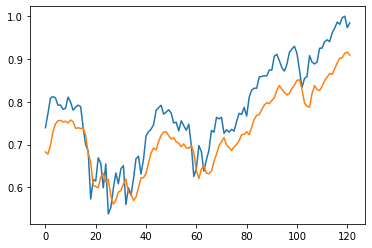

In [88]:
plt.plot(y_t)
plt.plot(model.predict(x_t))